# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 67135.33 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 94100.63 examples/s]

Filter (num_proc=6):  47%|████▋     | 52374/112120 [00:00<00:00, 102481.37 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 137277.89 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 146288.11 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  12%|█▏        | 14000/112120 [00:00<00:02, 46637.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105051.98 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 141144.79 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 141422.86 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:11, 15.01 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.09 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.46 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.11 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.31 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.53 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.41 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.74 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.85 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.46 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.29 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.24 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.11 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.70 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.68 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.53 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.11 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.51 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.71 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.93 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.05 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.43 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.01 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.87 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.83 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.38 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.22 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 46.66 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.55 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.72 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.20 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.38 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.93 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:03<00:07,  9.36 examples/s]

Map:  64%|██████▍   | 64/100 [00:04<00:02, 16.08 examples/s]

Map:  96%|█████████▌| 96/100 [00:05<00:00, 21.02 examples/s]

Map: 100%|██████████| 100/100 [00:05<00:00, 21.16 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:03<00:18,  9.14 examples/s]

Map:  32%|███▏      | 64/200 [00:04<00:08, 15.70 examples/s]

Map:  48%|████▊     | 96/200 [00:05<00:05, 20.20 examples/s]

Map:  64%|██████▍   | 128/200 [00:06<00:03, 21.28 examples/s]

Map:  80%|████████  | 160/200 [00:08<00:01, 23.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:09<00:00, 24.30 examples/s]

Map: 100%|██████████| 200/200 [00:09<00:00, 24.23 examples/s]

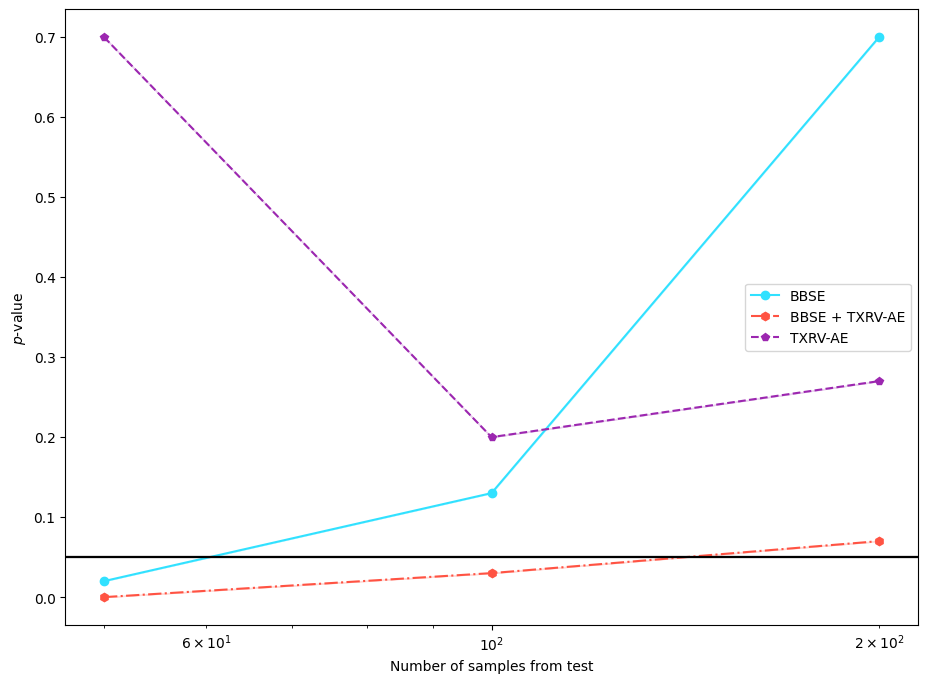

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:15, 11.01 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 21.18 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 29.99 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:01, 37.32 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:00, 43.41 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 47.31 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.89 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.15 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.36 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.12 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.73 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.60 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.49 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.51 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.72 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.35 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.97 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.14 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.61 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.50 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.28 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.10 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.15 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.64 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.35 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.72 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.17 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.41 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.42 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.14 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.51 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.98 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.35 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.29 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.38 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.29 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.08 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.68 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.07 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.21 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.69 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.10 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.70 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.18 examples/s]

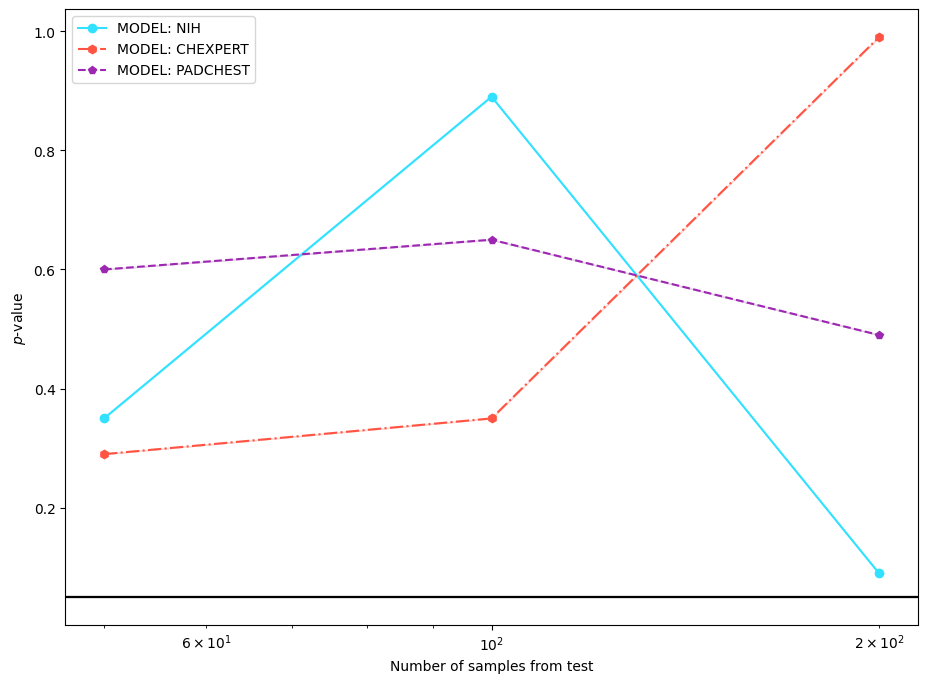

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55328.65 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80066.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94742.48 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102733.77 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110473.52 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112624.38 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51966.96 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77705.88 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92526.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101838.37 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107947.92 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112634.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.66 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.65 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.44 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.01 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.19 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.69 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.06 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.78 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.39 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.98 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.77 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.91 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.70 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.31 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.87 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56519.12 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79600.72 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92794.42 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100246.11 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 104886.21 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108895.24 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51329.90 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71532.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 81702.38 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91110.14 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99015.50 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 105520.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.70 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.57 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.46 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.23 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.14 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.04 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.95 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.26 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.55 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.74 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.04 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.11 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.60 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55005.63 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79405.81 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88429.50 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98032.22 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104235.42 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108646.35 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53703.20 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70785.40 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 82036.43 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90961.42 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98450.04 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 104974.79 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.22 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.71 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.36 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.45 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.14 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.29 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.34 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.87 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.51 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.37 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.13 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.58 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.61 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.18 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50481.51 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69209.44 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 81297.80 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 89907.06 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100014.59 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 105706.14 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54064.11 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78005.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92581.34 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100762.98 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105325.36 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109490.94 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.12 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.34 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.95 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.93 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.59 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.18 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.31 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.48 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 30.40 examples/s]

Map: 100%|██████████| 100/100 [00:03<00:00, 28.68 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.39 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.12 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.33 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.26 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.93 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.71 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.94 examples/s]

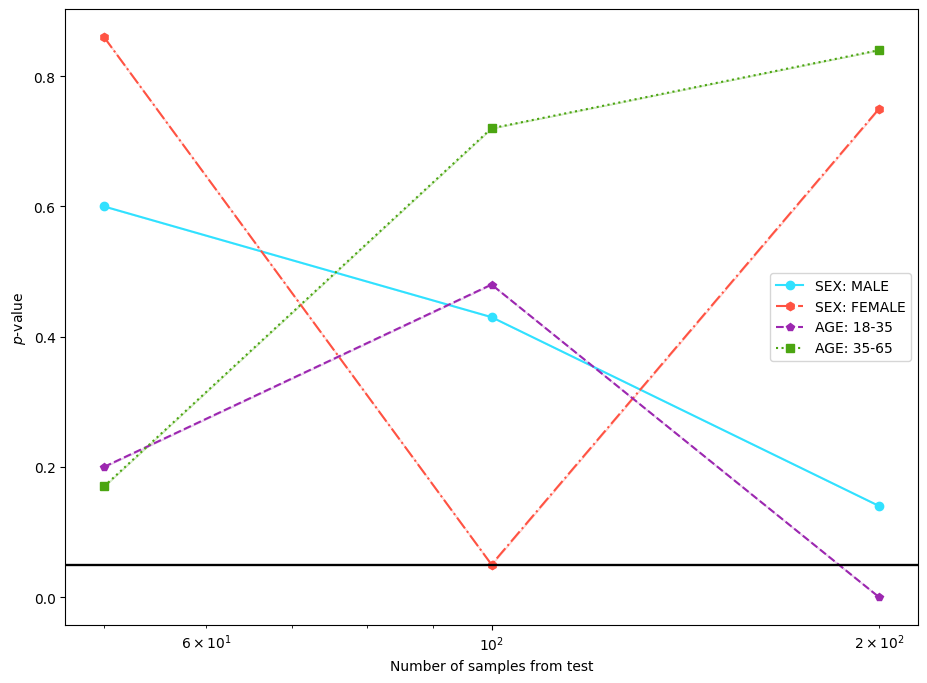

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.75 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.58 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.59 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.11 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.61 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.21 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.45 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.70 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.31 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.19 examples/s]

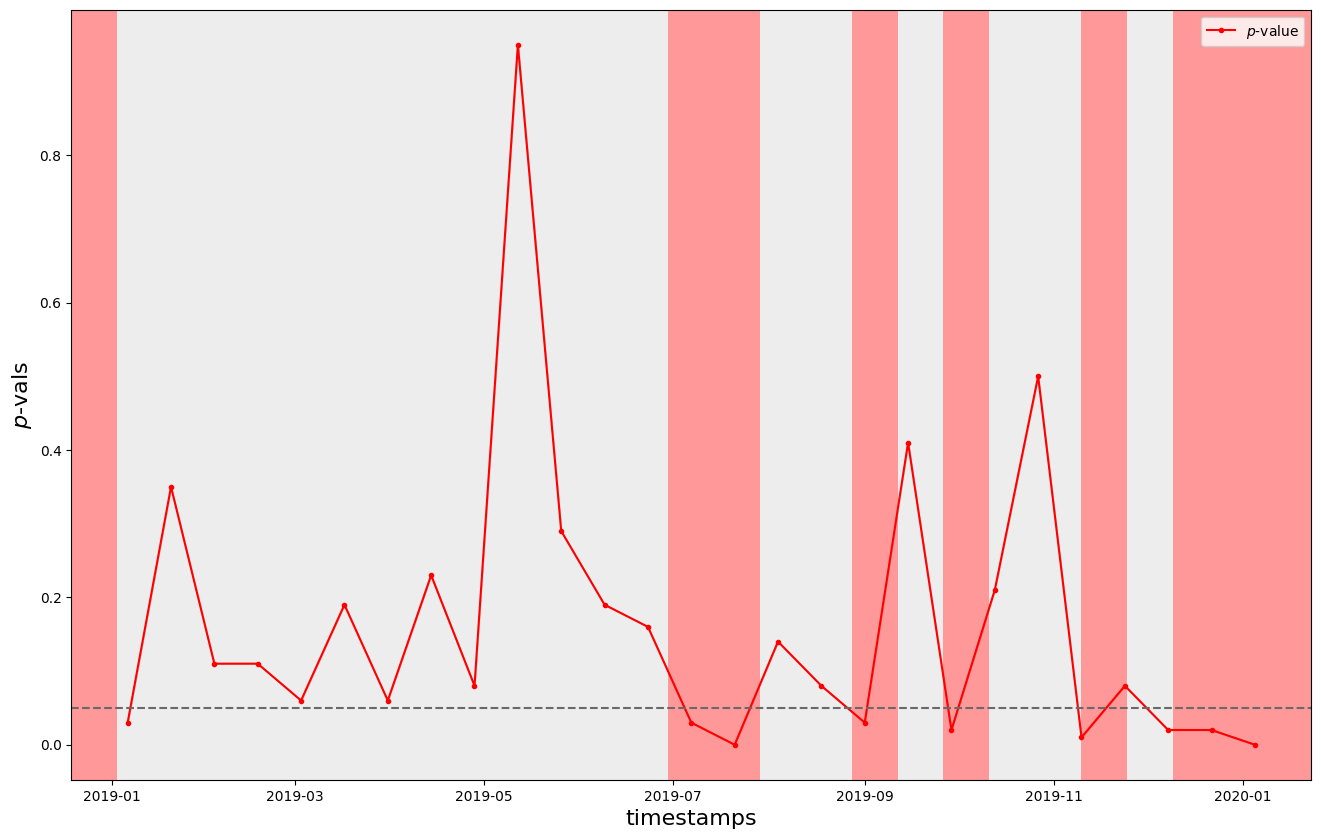

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)